# Deep Convolutional GAN

### Import Tensorflow & Download data

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", reshape=False, validation_size=0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Build Network

#### Inputs

In [3]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    return inputs_real, inputs_z

#### Generator

In [4]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.sigmoid(logits)
        
        return out

#### Discriminator

In [5]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x1
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

#### Model Loss

In [6]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

#### Optimizers

In [7]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

#### Hyper Parameters

In [8]:
real_size = (28,28,1)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 10
alpha = 0.2
beta1 = 0.5

#### Define Model

In [9]:
tf.reset_default_graph()

input_real, input_z = model_inputs(real_size, z_size)

d_loss, g_loss = model_loss(input_real, input_z, real_size[2], alpha=alpha)

d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

#### view_samples

In [10]:
def view_samples(epoch, samples):
    
    fig, axes = plt.subplots(figsize=(7, 7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
    
    return fig, axes

## Training

Epoch 1/10... Discriminator Loss: 0.0351... Generator Loss: 4.2114
Epoch 1/10... Discriminator Loss: 0.1093... Generator Loss: 13.9183
Epoch 1/10... Discriminator Loss: 0.0710... Generator Loss: 2.8001
Epoch 1/10... Discriminator Loss: 0.0474... Generator Loss: 3.9060
Epoch 1/10... Discriminator Loss: 0.0452... Generator Loss: 3.7032
Epoch 1/10... Discriminator Loss: 0.0279... Generator Loss: 4.1513
Epoch 1/10... Discriminator Loss: 0.0272... Generator Loss: 4.1735
Epoch 1/10... Discriminator Loss: 0.1418... Generator Loss: 2.1591
Epoch 1/10... Discriminator Loss: 0.7933... Generator Loss: 0.7653
Epoch 1/10... Discriminator Loss: 0.1551... Generator Loss: 12.2330


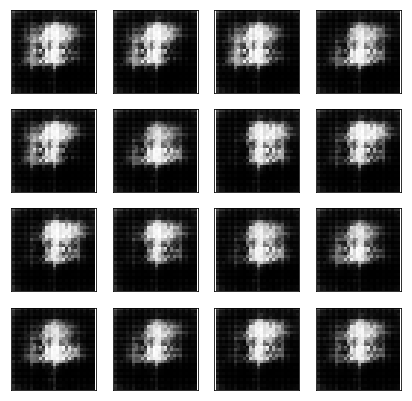

Epoch 1/10... Discriminator Loss: 0.0429... Generator Loss: 6.4644
Epoch 1/10... Discriminator Loss: 0.6875... Generator Loss: 13.0754
Epoch 1/10... Discriminator Loss: 0.1050... Generator Loss: 4.5472
Epoch 1/10... Discriminator Loss: 0.0773... Generator Loss: 3.2685
Epoch 1/10... Discriminator Loss: 0.1862... Generator Loss: 2.6961
Epoch 1/10... Discriminator Loss: 0.1424... Generator Loss: 3.1470
Epoch 1/10... Discriminator Loss: 0.1574... Generator Loss: 2.8757
Epoch 1/10... Discriminator Loss: 0.1518... Generator Loss: 2.8625
Epoch 1/10... Discriminator Loss: 0.0985... Generator Loss: 6.3181
Epoch 1/10... Discriminator Loss: 0.1206... Generator Loss: 3.1591


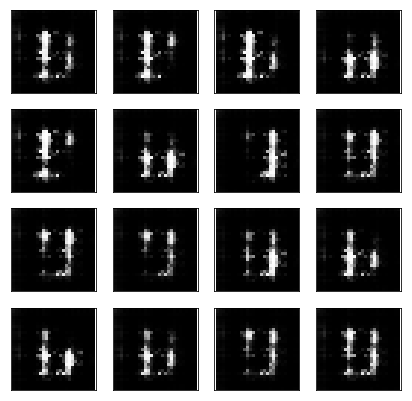

Epoch 1/10... Discriminator Loss: 0.0846... Generator Loss: 3.6659
Epoch 1/10... Discriminator Loss: 0.0971... Generator Loss: 3.4108
Epoch 1/10... Discriminator Loss: 0.0355... Generator Loss: 4.7895
Epoch 1/10... Discriminator Loss: 0.0466... Generator Loss: 4.0464
Epoch 1/10... Discriminator Loss: 0.1194... Generator Loss: 3.5642
Epoch 1/10... Discriminator Loss: 0.0460... Generator Loss: 4.8818
Epoch 1/10... Discriminator Loss: 0.1162... Generator Loss: 4.0675
Epoch 1/10... Discriminator Loss: 0.0965... Generator Loss: 3.2920
Epoch 1/10... Discriminator Loss: 0.0922... Generator Loss: 3.6286
Epoch 1/10... Discriminator Loss: 0.0634... Generator Loss: 4.2567


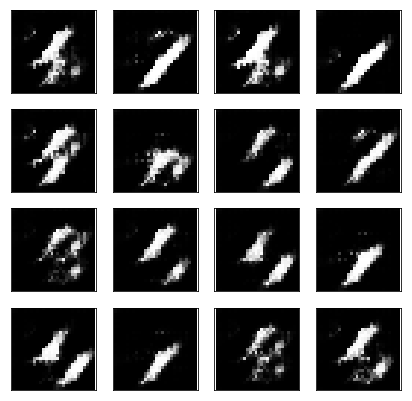

Epoch 1/10... Discriminator Loss: 0.1036... Generator Loss: 3.2982
Epoch 1/10... Discriminator Loss: 0.1202... Generator Loss: 3.3805
Epoch 1/10... Discriminator Loss: 0.1204... Generator Loss: 3.5760
Epoch 1/10... Discriminator Loss: 0.1697... Generator Loss: 6.6033
Epoch 1/10... Discriminator Loss: 0.1021... Generator Loss: 5.9242
Epoch 1/10... Discriminator Loss: 0.0864... Generator Loss: 4.0038
Epoch 1/10... Discriminator Loss: 0.0518... Generator Loss: 4.7603
Epoch 1/10... Discriminator Loss: 0.1409... Generator Loss: 3.9582
Epoch 1/10... Discriminator Loss: 0.0756... Generator Loss: 4.2929
Epoch 1/10... Discriminator Loss: 0.0922... Generator Loss: 3.4716


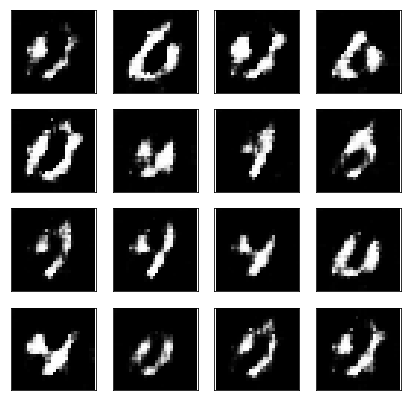

Epoch 1/10... Discriminator Loss: 0.1661... Generator Loss: 2.7608
Epoch 1/10... Discriminator Loss: 0.0682... Generator Loss: 3.9645
Epoch 1/10... Discriminator Loss: 0.1354... Generator Loss: 3.1347
Epoch 1/10... Discriminator Loss: 0.3555... Generator Loss: 1.8577
Epoch 1/10... Discriminator Loss: 0.1406... Generator Loss: 4.3552
Epoch 1/10... Discriminator Loss: 0.1121... Generator Loss: 3.5015
Epoch 2/10... Discriminator Loss: 0.0806... Generator Loss: 4.0883
Epoch 2/10... Discriminator Loss: 0.1224... Generator Loss: 3.5916
Epoch 2/10... Discriminator Loss: 0.1367... Generator Loss: 4.1136
Epoch 2/10... Discriminator Loss: 0.1038... Generator Loss: 4.7899


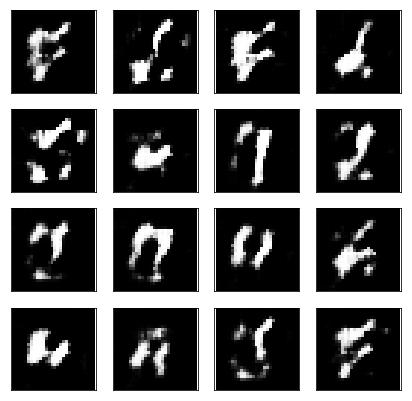

Epoch 2/10... Discriminator Loss: 1.2725... Generator Loss: 11.8256
Epoch 2/10... Discriminator Loss: 0.1573... Generator Loss: 3.8374
Epoch 2/10... Discriminator Loss: 0.1925... Generator Loss: 2.8413
Epoch 2/10... Discriminator Loss: 0.2124... Generator Loss: 2.9128
Epoch 2/10... Discriminator Loss: 0.1523... Generator Loss: 3.2092
Epoch 2/10... Discriminator Loss: 0.3612... Generator Loss: 1.9111
Epoch 2/10... Discriminator Loss: 0.2459... Generator Loss: 3.1800
Epoch 2/10... Discriminator Loss: 0.4468... Generator Loss: 1.8702
Epoch 2/10... Discriminator Loss: 0.1825... Generator Loss: 3.7734
Epoch 2/10... Discriminator Loss: 0.1536... Generator Loss: 3.3625


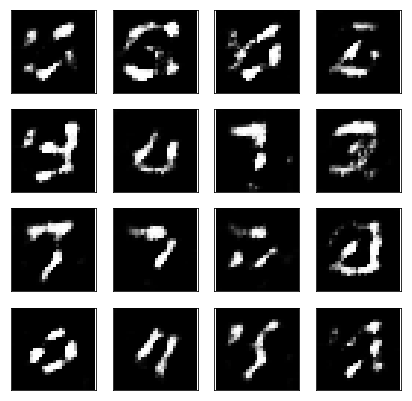

Epoch 2/10... Discriminator Loss: 0.2916... Generator Loss: 2.3012
Epoch 2/10... Discriminator Loss: 0.1657... Generator Loss: 3.4905
Epoch 2/10... Discriminator Loss: 0.2652... Generator Loss: 3.6738
Epoch 2/10... Discriminator Loss: 0.2147... Generator Loss: 3.7243
Epoch 2/10... Discriminator Loss: 0.2815... Generator Loss: 4.5590
Epoch 2/10... Discriminator Loss: 0.1448... Generator Loss: 3.6266
Epoch 2/10... Discriminator Loss: 0.2944... Generator Loss: 2.3456
Epoch 2/10... Discriminator Loss: 0.2029... Generator Loss: 3.1263
Epoch 2/10... Discriminator Loss: 0.2961... Generator Loss: 2.8018
Epoch 2/10... Discriminator Loss: 0.2666... Generator Loss: 2.7701


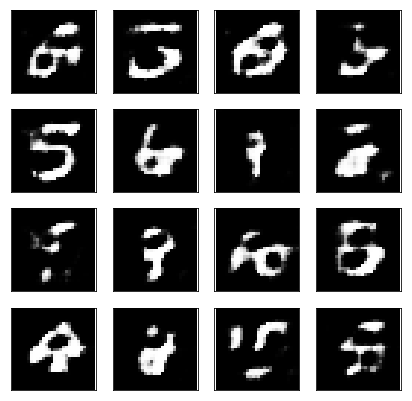

Epoch 2/10... Discriminator Loss: 0.1861... Generator Loss: 3.3100
Epoch 2/10... Discriminator Loss: 0.2251... Generator Loss: 2.6816
Epoch 2/10... Discriminator Loss: 0.2309... Generator Loss: 3.4973
Epoch 2/10... Discriminator Loss: 0.4062... Generator Loss: 1.7640
Epoch 2/10... Discriminator Loss: 0.4681... Generator Loss: 1.7148
Epoch 2/10... Discriminator Loss: 0.9249... Generator Loss: 5.4265
Epoch 2/10... Discriminator Loss: 0.2844... Generator Loss: 2.8931
Epoch 2/10... Discriminator Loss: 0.2544... Generator Loss: 2.4198
Epoch 2/10... Discriminator Loss: 0.8330... Generator Loss: 1.0963
Epoch 2/10... Discriminator Loss: 0.2962... Generator Loss: 3.0631


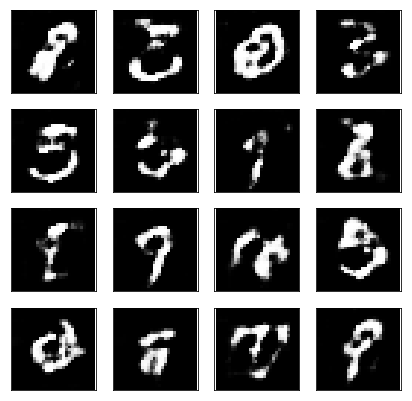

Epoch 2/10... Discriminator Loss: 0.2990... Generator Loss: 2.6691
Epoch 2/10... Discriminator Loss: 0.2235... Generator Loss: 3.2770
Epoch 2/10... Discriminator Loss: 0.5465... Generator Loss: 1.6927
Epoch 2/10... Discriminator Loss: 0.3808... Generator Loss: 2.4717
Epoch 2/10... Discriminator Loss: 0.4184... Generator Loss: 2.5335
Epoch 2/10... Discriminator Loss: 0.3191... Generator Loss: 2.6551
Epoch 2/10... Discriminator Loss: 0.3891... Generator Loss: 2.9803
Epoch 2/10... Discriminator Loss: 0.5474... Generator Loss: 3.8734
Epoch 2/10... Discriminator Loss: 0.4334... Generator Loss: 1.9217
Epoch 2/10... Discriminator Loss: 0.3043... Generator Loss: 2.3542


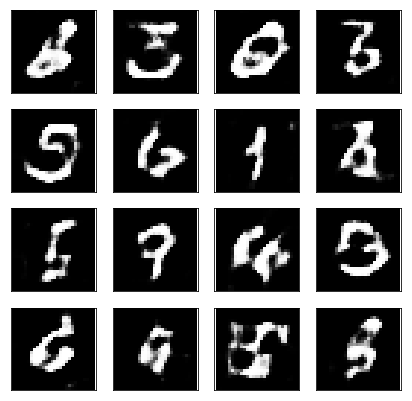

Epoch 2/10... Discriminator Loss: 0.7850... Generator Loss: 3.6884
Epoch 2/10... Discriminator Loss: 0.7929... Generator Loss: 1.0322
Epoch 2/10... Discriminator Loss: 0.6039... Generator Loss: 1.2298
Epoch 3/10... Discriminator Loss: 0.3970... Generator Loss: 1.8018
Epoch 3/10... Discriminator Loss: 0.3600... Generator Loss: 2.5111
Epoch 3/10... Discriminator Loss: 0.7331... Generator Loss: 1.1185
Epoch 3/10... Discriminator Loss: 0.4139... Generator Loss: 2.3563
Epoch 3/10... Discriminator Loss: 0.5995... Generator Loss: 1.2616
Epoch 3/10... Discriminator Loss: 0.5460... Generator Loss: 1.5321
Epoch 3/10... Discriminator Loss: 0.4844... Generator Loss: 1.7606


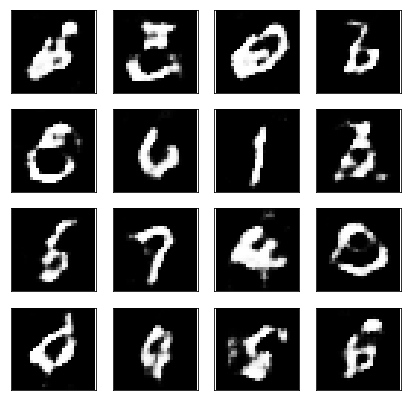

Epoch 3/10... Discriminator Loss: 0.5655... Generator Loss: 1.3819
Epoch 3/10... Discriminator Loss: 0.3787... Generator Loss: 2.2469
Epoch 3/10... Discriminator Loss: 0.4404... Generator Loss: 1.9474
Epoch 3/10... Discriminator Loss: 0.4603... Generator Loss: 2.9231
Epoch 3/10... Discriminator Loss: 0.4208... Generator Loss: 1.6572
Epoch 3/10... Discriminator Loss: 0.4506... Generator Loss: 2.1730
Epoch 3/10... Discriminator Loss: 0.4267... Generator Loss: 1.8487
Epoch 3/10... Discriminator Loss: 0.6301... Generator Loss: 3.0307
Epoch 3/10... Discriminator Loss: 1.3430... Generator Loss: 4.4685
Epoch 3/10... Discriminator Loss: 0.5245... Generator Loss: 1.7271


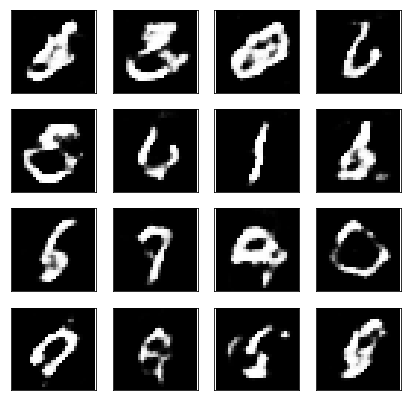

Epoch 3/10... Discriminator Loss: 0.4989... Generator Loss: 1.9952
Epoch 3/10... Discriminator Loss: 0.5517... Generator Loss: 2.5968
Epoch 3/10... Discriminator Loss: 0.4929... Generator Loss: 1.4615
Epoch 3/10... Discriminator Loss: 0.5530... Generator Loss: 1.7977
Epoch 3/10... Discriminator Loss: 0.4145... Generator Loss: 2.4207
Epoch 3/10... Discriminator Loss: 0.5317... Generator Loss: 1.3677
Epoch 3/10... Discriminator Loss: 0.5350... Generator Loss: 1.5133
Epoch 3/10... Discriminator Loss: 0.4250... Generator Loss: 1.9179
Epoch 3/10... Discriminator Loss: 0.6873... Generator Loss: 1.1260
Epoch 3/10... Discriminator Loss: 0.8165... Generator Loss: 0.8498


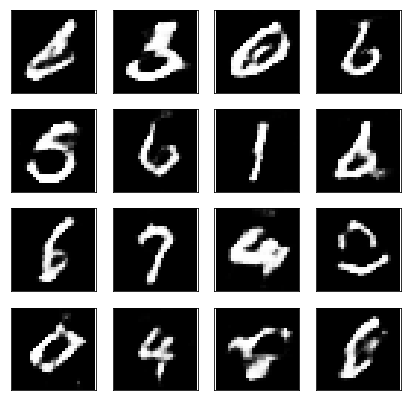

Epoch 3/10... Discriminator Loss: 0.7241... Generator Loss: 3.1345
Epoch 3/10... Discriminator Loss: 0.4885... Generator Loss: 1.5999
Epoch 3/10... Discriminator Loss: 0.5351... Generator Loss: 1.5265
Epoch 3/10... Discriminator Loss: 0.5380... Generator Loss: 1.3031
Epoch 3/10... Discriminator Loss: 0.6457... Generator Loss: 1.1500
Epoch 3/10... Discriminator Loss: 0.7065... Generator Loss: 2.5016
Epoch 3/10... Discriminator Loss: 0.5710... Generator Loss: 1.5068
Epoch 3/10... Discriminator Loss: 0.5338... Generator Loss: 1.5060
Epoch 3/10... Discriminator Loss: 1.0616... Generator Loss: 3.5073
Epoch 3/10... Discriminator Loss: 0.7164... Generator Loss: 2.4671


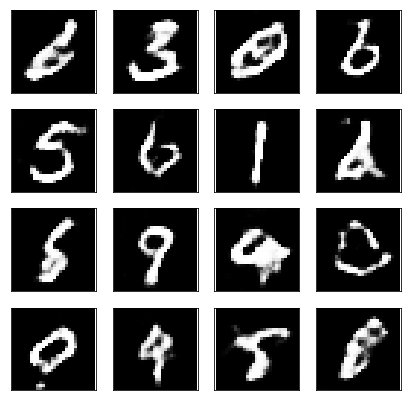

Epoch 3/10... Discriminator Loss: 1.2638... Generator Loss: 3.9047
Epoch 3/10... Discriminator Loss: 0.5048... Generator Loss: 1.7830
Epoch 3/10... Discriminator Loss: 0.6246... Generator Loss: 1.1858
Epoch 3/10... Discriminator Loss: 0.5421... Generator Loss: 1.4394
Epoch 3/10... Discriminator Loss: 0.7020... Generator Loss: 2.1582
Epoch 3/10... Discriminator Loss: 0.6262... Generator Loss: 1.2437
Epoch 3/10... Discriminator Loss: 0.6043... Generator Loss: 1.7337
Epoch 3/10... Discriminator Loss: 0.6217... Generator Loss: 1.4684
Epoch 3/10... Discriminator Loss: 0.5412... Generator Loss: 1.8089
Epoch 3/10... Discriminator Loss: 1.0925... Generator Loss: 0.6026


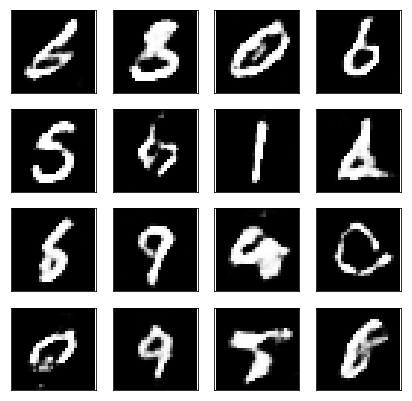

Epoch 4/10... Discriminator Loss: 0.8065... Generator Loss: 0.8918
Epoch 4/10... Discriminator Loss: 0.5837... Generator Loss: 1.3472
Epoch 4/10... Discriminator Loss: 0.6541... Generator Loss: 1.0979
Epoch 4/10... Discriminator Loss: 0.6008... Generator Loss: 1.3983
Epoch 4/10... Discriminator Loss: 0.9006... Generator Loss: 0.7637
Epoch 4/10... Discriminator Loss: 0.6306... Generator Loss: 1.1829
Epoch 4/10... Discriminator Loss: 0.8939... Generator Loss: 0.7792
Epoch 4/10... Discriminator Loss: 0.5978... Generator Loss: 1.5980
Epoch 4/10... Discriminator Loss: 0.9628... Generator Loss: 0.7313
Epoch 4/10... Discriminator Loss: 0.5762... Generator Loss: 1.6241


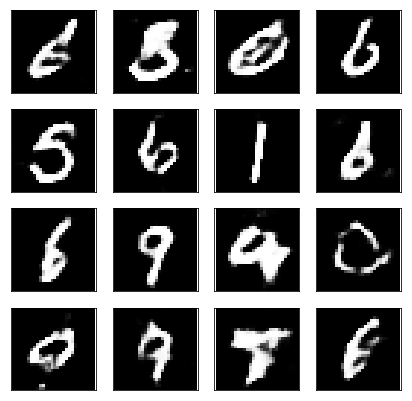

Epoch 4/10... Discriminator Loss: 0.5273... Generator Loss: 1.5422
Epoch 4/10... Discriminator Loss: 0.5779... Generator Loss: 1.2870
Epoch 4/10... Discriminator Loss: 0.8848... Generator Loss: 2.9737
Epoch 4/10... Discriminator Loss: 1.2456... Generator Loss: 3.4898
Epoch 4/10... Discriminator Loss: 0.6209... Generator Loss: 1.7816
Epoch 4/10... Discriminator Loss: 0.8486... Generator Loss: 2.6666
Epoch 4/10... Discriminator Loss: 0.6393... Generator Loss: 1.3075
Epoch 4/10... Discriminator Loss: 0.5777... Generator Loss: 1.5744
Epoch 4/10... Discriminator Loss: 0.6456... Generator Loss: 1.2249
Epoch 4/10... Discriminator Loss: 0.5848... Generator Loss: 2.0877


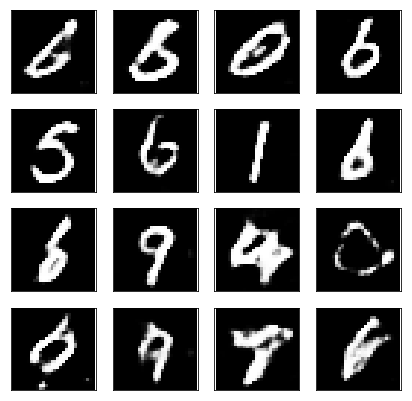

Epoch 4/10... Discriminator Loss: 1.0138... Generator Loss: 0.6548
Epoch 4/10... Discriminator Loss: 0.6043... Generator Loss: 1.5268
Epoch 4/10... Discriminator Loss: 0.5204... Generator Loss: 1.6027
Epoch 4/10... Discriminator Loss: 0.5289... Generator Loss: 1.5802
Epoch 4/10... Discriminator Loss: 0.7104... Generator Loss: 1.2081
Epoch 4/10... Discriminator Loss: 0.5636... Generator Loss: 1.9406
Epoch 4/10... Discriminator Loss: 0.6137... Generator Loss: 1.5743
Epoch 4/10... Discriminator Loss: 0.6931... Generator Loss: 2.1789
Epoch 4/10... Discriminator Loss: 0.5550... Generator Loss: 1.7830
Epoch 4/10... Discriminator Loss: 0.9514... Generator Loss: 2.9928


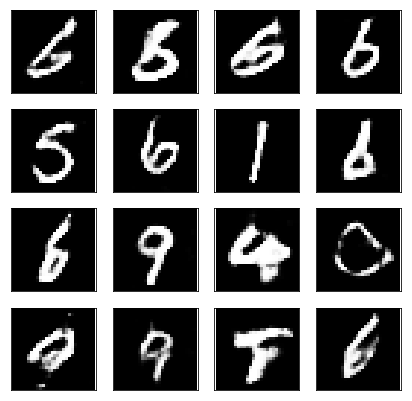

Epoch 4/10... Discriminator Loss: 0.6605... Generator Loss: 1.1885
Epoch 4/10... Discriminator Loss: 1.2900... Generator Loss: 0.4765
Epoch 4/10... Discriminator Loss: 1.0536... Generator Loss: 0.6120
Epoch 4/10... Discriminator Loss: 0.6263... Generator Loss: 1.2844
Epoch 4/10... Discriminator Loss: 0.6063... Generator Loss: 1.2155
Epoch 4/10... Discriminator Loss: 0.9164... Generator Loss: 0.7663
Epoch 4/10... Discriminator Loss: 1.0400... Generator Loss: 0.6368
Epoch 4/10... Discriminator Loss: 0.6849... Generator Loss: 1.0749
Epoch 4/10... Discriminator Loss: 0.8268... Generator Loss: 0.8408
Epoch 4/10... Discriminator Loss: 1.1997... Generator Loss: 0.5153


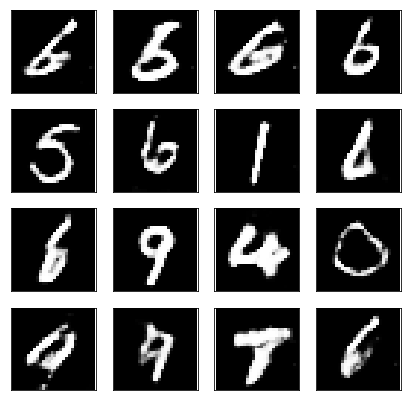

Epoch 4/10... Discriminator Loss: 0.9048... Generator Loss: 0.7587
Epoch 4/10... Discriminator Loss: 0.6507... Generator Loss: 1.2616
Epoch 4/10... Discriminator Loss: 0.6189... Generator Loss: 2.1042
Epoch 4/10... Discriminator Loss: 0.7232... Generator Loss: 2.4336
Epoch 4/10... Discriminator Loss: 0.6665... Generator Loss: 1.0795
Epoch 4/10... Discriminator Loss: 0.7264... Generator Loss: 0.9492
Epoch 4/10... Discriminator Loss: 0.4767... Generator Loss: 1.6516
Epoch 5/10... Discriminator Loss: 0.9347... Generator Loss: 0.6797
Epoch 5/10... Discriminator Loss: 0.8508... Generator Loss: 0.8207
Epoch 5/10... Discriminator Loss: 0.6288... Generator Loss: 1.5065


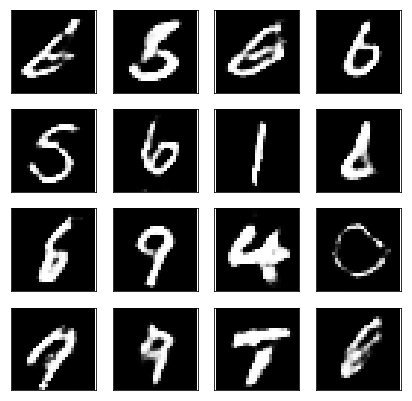

Epoch 5/10... Discriminator Loss: 0.6446... Generator Loss: 2.3127
Epoch 5/10... Discriminator Loss: 0.4793... Generator Loss: 1.5561
Epoch 5/10... Discriminator Loss: 1.2080... Generator Loss: 0.4939
Epoch 5/10... Discriminator Loss: 0.6300... Generator Loss: 1.1165
Epoch 5/10... Discriminator Loss: 0.8972... Generator Loss: 0.7223
Epoch 5/10... Discriminator Loss: 0.6656... Generator Loss: 1.1780
Epoch 5/10... Discriminator Loss: 0.8812... Generator Loss: 0.7400
Epoch 5/10... Discriminator Loss: 0.5606... Generator Loss: 1.3304
Epoch 5/10... Discriminator Loss: 0.8378... Generator Loss: 0.8468
Epoch 5/10... Discriminator Loss: 0.7526... Generator Loss: 0.8643


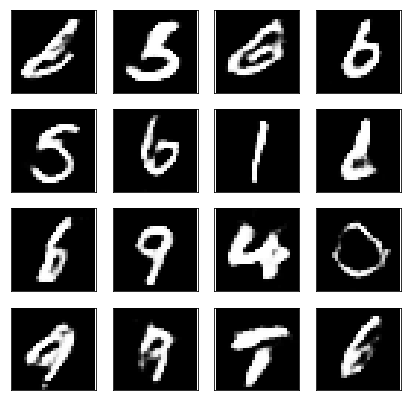

Epoch 5/10... Discriminator Loss: 0.5172... Generator Loss: 1.9415
Epoch 5/10... Discriminator Loss: 0.6531... Generator Loss: 2.5467
Epoch 5/10... Discriminator Loss: 0.5037... Generator Loss: 1.6301
Epoch 5/10... Discriminator Loss: 0.8051... Generator Loss: 1.1787
Epoch 5/10... Discriminator Loss: 1.2828... Generator Loss: 0.4424
Epoch 5/10... Discriminator Loss: 0.5689... Generator Loss: 1.8350
Epoch 5/10... Discriminator Loss: 0.5423... Generator Loss: 1.2657
Epoch 5/10... Discriminator Loss: 1.0536... Generator Loss: 0.5897
Epoch 5/10... Discriminator Loss: 0.5437... Generator Loss: 1.9424
Epoch 5/10... Discriminator Loss: 0.6986... Generator Loss: 1.0028


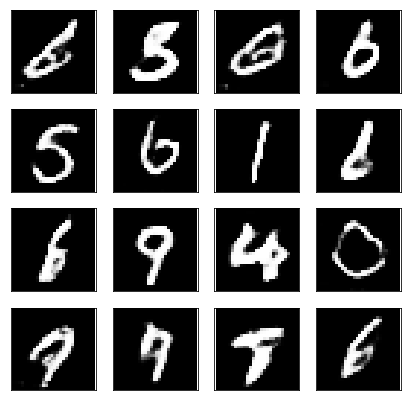

Epoch 5/10... Discriminator Loss: 0.7143... Generator Loss: 2.4167
Epoch 5/10... Discriminator Loss: 0.8729... Generator Loss: 0.7976
Epoch 5/10... Discriminator Loss: 1.0979... Generator Loss: 0.5705
Epoch 5/10... Discriminator Loss: 0.7098... Generator Loss: 1.0083
Epoch 5/10... Discriminator Loss: 0.9240... Generator Loss: 3.5960
Epoch 5/10... Discriminator Loss: 0.4917... Generator Loss: 2.1517
Epoch 5/10... Discriminator Loss: 0.4974... Generator Loss: 1.4366
Epoch 5/10... Discriminator Loss: 0.7023... Generator Loss: 2.5392
Epoch 5/10... Discriminator Loss: 0.5319... Generator Loss: 1.9668
Epoch 5/10... Discriminator Loss: 0.9785... Generator Loss: 0.6940


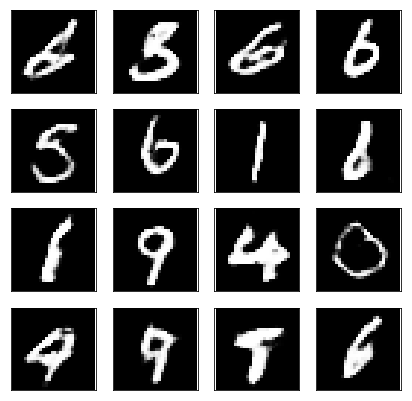

Epoch 5/10... Discriminator Loss: 0.8762... Generator Loss: 0.7904
Epoch 5/10... Discriminator Loss: 0.7829... Generator Loss: 3.0377
Epoch 5/10... Discriminator Loss: 0.7273... Generator Loss: 1.9277
Epoch 5/10... Discriminator Loss: 1.0205... Generator Loss: 2.7719
Epoch 5/10... Discriminator Loss: 0.7210... Generator Loss: 0.9711
Epoch 5/10... Discriminator Loss: 0.8961... Generator Loss: 0.7670
Epoch 5/10... Discriminator Loss: 0.5504... Generator Loss: 1.7780
Epoch 5/10... Discriminator Loss: 0.8554... Generator Loss: 0.8154
Epoch 5/10... Discriminator Loss: 0.7072... Generator Loss: 2.8040
Epoch 5/10... Discriminator Loss: 0.7572... Generator Loss: 2.6231


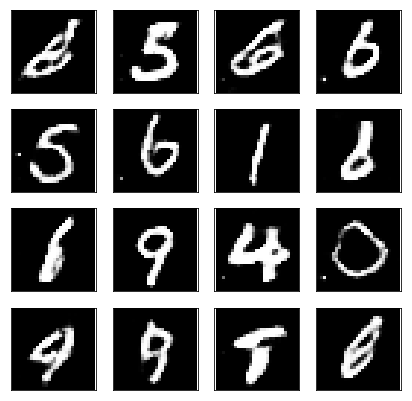

Epoch 5/10... Discriminator Loss: 0.6894... Generator Loss: 1.8400
Epoch 5/10... Discriminator Loss: 0.5973... Generator Loss: 1.5595
Epoch 5/10... Discriminator Loss: 0.6615... Generator Loss: 1.0787
Epoch 5/10... Discriminator Loss: 0.4993... Generator Loss: 1.9616
Epoch 6/10... Discriminator Loss: 0.6086... Generator Loss: 1.2910
Epoch 6/10... Discriminator Loss: 2.3219... Generator Loss: 0.2493
Epoch 6/10... Discriminator Loss: 0.8081... Generator Loss: 0.9186
Epoch 6/10... Discriminator Loss: 0.7901... Generator Loss: 1.3972
Epoch 6/10... Discriminator Loss: 0.5784... Generator Loss: 1.4941
Epoch 6/10... Discriminator Loss: 0.9371... Generator Loss: 0.6735


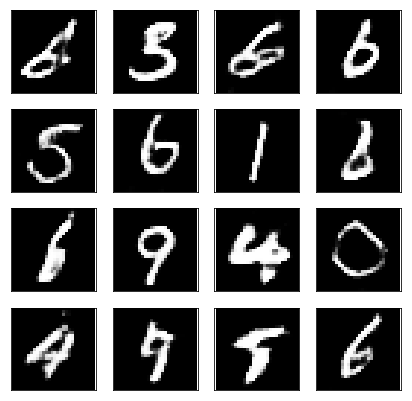

Epoch 6/10... Discriminator Loss: 0.6540... Generator Loss: 1.2864
Epoch 6/10... Discriminator Loss: 0.7775... Generator Loss: 0.9177
Epoch 6/10... Discriminator Loss: 0.9887... Generator Loss: 0.6718
Epoch 6/10... Discriminator Loss: 1.0095... Generator Loss: 2.8766
Epoch 6/10... Discriminator Loss: 1.0559... Generator Loss: 0.6074
Epoch 6/10... Discriminator Loss: 1.1467... Generator Loss: 0.5471
Epoch 6/10... Discriminator Loss: 0.7827... Generator Loss: 0.8747
Epoch 6/10... Discriminator Loss: 0.9230... Generator Loss: 0.7299
Epoch 6/10... Discriminator Loss: 0.5320... Generator Loss: 2.1573
Epoch 6/10... Discriminator Loss: 0.7833... Generator Loss: 0.9569


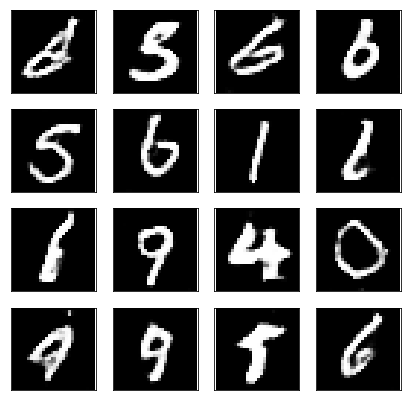

Epoch 6/10... Discriminator Loss: 0.5635... Generator Loss: 1.7690
Epoch 6/10... Discriminator Loss: 0.7458... Generator Loss: 0.9365
Epoch 6/10... Discriminator Loss: 0.6111... Generator Loss: 1.2618
Epoch 6/10... Discriminator Loss: 0.4578... Generator Loss: 1.5468
Epoch 6/10... Discriminator Loss: 0.6773... Generator Loss: 2.4449
Epoch 6/10... Discriminator Loss: 0.8485... Generator Loss: 0.7855
Epoch 6/10... Discriminator Loss: 0.6339... Generator Loss: 1.8144
Epoch 6/10... Discriminator Loss: 0.6318... Generator Loss: 1.9082
Epoch 6/10... Discriminator Loss: 0.8264... Generator Loss: 2.6791
Epoch 6/10... Discriminator Loss: 0.9717... Generator Loss: 0.6464


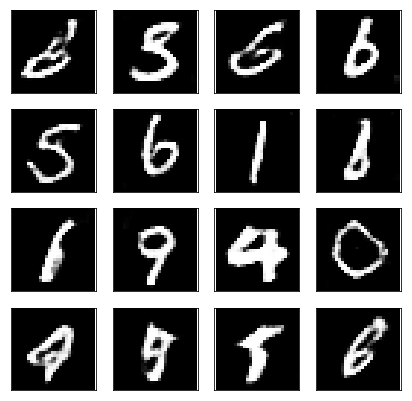

Epoch 6/10... Discriminator Loss: 0.7457... Generator Loss: 1.3480
Epoch 6/10... Discriminator Loss: 1.3152... Generator Loss: 3.8073
Epoch 6/10... Discriminator Loss: 0.8085... Generator Loss: 0.8690
Epoch 6/10... Discriminator Loss: 1.9265... Generator Loss: 0.2239
Epoch 6/10... Discriminator Loss: 0.7266... Generator Loss: 1.2502
Epoch 6/10... Discriminator Loss: 0.9801... Generator Loss: 0.6936
Epoch 6/10... Discriminator Loss: 0.7742... Generator Loss: 0.9106
Epoch 6/10... Discriminator Loss: 0.7015... Generator Loss: 1.3939
Epoch 6/10... Discriminator Loss: 0.8638... Generator Loss: 0.7954
Epoch 6/10... Discriminator Loss: 0.7031... Generator Loss: 1.0182


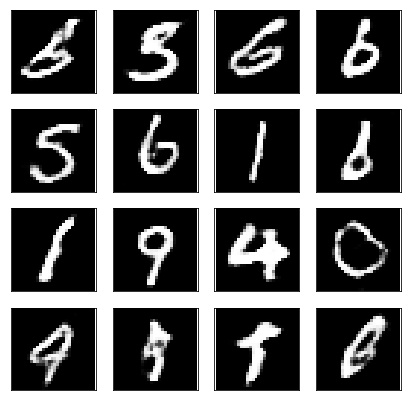

Epoch 6/10... Discriminator Loss: 0.7452... Generator Loss: 0.9547
Epoch 6/10... Discriminator Loss: 0.6600... Generator Loss: 1.5821
Epoch 6/10... Discriminator Loss: 0.5388... Generator Loss: 2.3334
Epoch 6/10... Discriminator Loss: 0.9139... Generator Loss: 0.6946
Epoch 6/10... Discriminator Loss: 0.6594... Generator Loss: 1.2221
Epoch 6/10... Discriminator Loss: 0.5590... Generator Loss: 1.6361
Epoch 6/10... Discriminator Loss: 0.7554... Generator Loss: 0.8942
Epoch 6/10... Discriminator Loss: 0.6153... Generator Loss: 1.1758
Epoch 6/10... Discriminator Loss: 0.8067... Generator Loss: 0.8325
Epoch 6/10... Discriminator Loss: 0.7218... Generator Loss: 1.4871


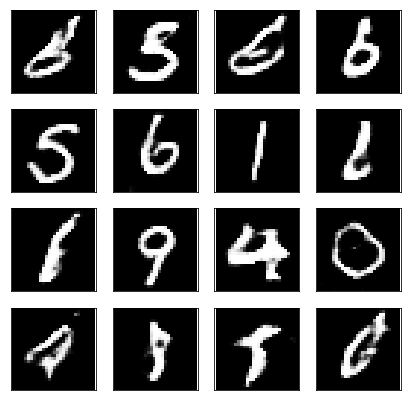

Epoch 7/10... Discriminator Loss: 0.8027... Generator Loss: 0.8546
Epoch 7/10... Discriminator Loss: 0.5747... Generator Loss: 1.2333
Epoch 7/10... Discriminator Loss: 0.6274... Generator Loss: 1.7670
Epoch 7/10... Discriminator Loss: 0.6301... Generator Loss: 1.9379
Epoch 7/10... Discriminator Loss: 0.6403... Generator Loss: 1.3428
Epoch 7/10... Discriminator Loss: 0.6239... Generator Loss: 1.7468
Epoch 7/10... Discriminator Loss: 0.6822... Generator Loss: 1.3459
Epoch 7/10... Discriminator Loss: 0.5577... Generator Loss: 1.9729
Epoch 7/10... Discriminator Loss: 0.4642... Generator Loss: 1.7701
Epoch 7/10... Discriminator Loss: 0.6584... Generator Loss: 1.1186


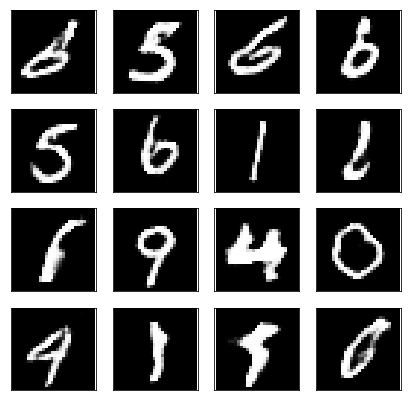

Epoch 7/10... Discriminator Loss: 0.6554... Generator Loss: 1.1957
Epoch 7/10... Discriminator Loss: 0.9632... Generator Loss: 0.6842
Epoch 7/10... Discriminator Loss: 0.5824... Generator Loss: 2.0263
Epoch 7/10... Discriminator Loss: 1.7808... Generator Loss: 0.3165
Epoch 7/10... Discriminator Loss: 0.9960... Generator Loss: 1.9254
Epoch 7/10... Discriminator Loss: 0.7309... Generator Loss: 1.7238
Epoch 7/10... Discriminator Loss: 0.8098... Generator Loss: 1.0970
Epoch 7/10... Discriminator Loss: 1.0592... Generator Loss: 3.0475
Epoch 7/10... Discriminator Loss: 0.6395... Generator Loss: 1.1992
Epoch 7/10... Discriminator Loss: 1.1078... Generator Loss: 0.5665


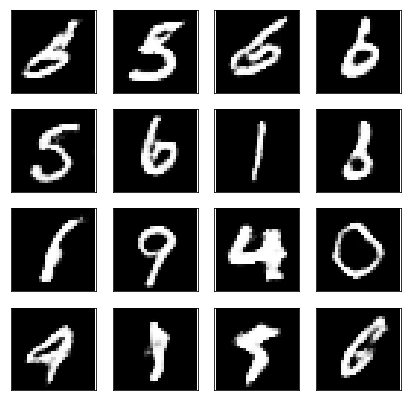

Epoch 7/10... Discriminator Loss: 0.7012... Generator Loss: 1.1187
Epoch 7/10... Discriminator Loss: 0.6735... Generator Loss: 1.1430
Epoch 7/10... Discriminator Loss: 0.7225... Generator Loss: 0.9925
Epoch 7/10... Discriminator Loss: 0.6439... Generator Loss: 1.2475
Epoch 7/10... Discriminator Loss: 0.6710... Generator Loss: 1.1257
Epoch 7/10... Discriminator Loss: 0.6289... Generator Loss: 1.0689
Epoch 7/10... Discriminator Loss: 1.8899... Generator Loss: 4.6263
Epoch 7/10... Discriminator Loss: 1.0198... Generator Loss: 0.6613
Epoch 7/10... Discriminator Loss: 0.6813... Generator Loss: 1.4890
Epoch 7/10... Discriminator Loss: 1.0732... Generator Loss: 0.5715


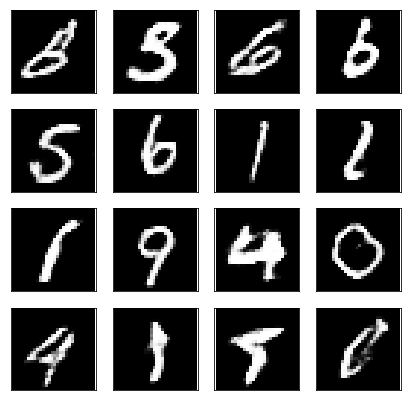

Epoch 7/10... Discriminator Loss: 0.5952... Generator Loss: 1.6039
Epoch 7/10... Discriminator Loss: 0.4918... Generator Loss: 1.7169
Epoch 7/10... Discriminator Loss: 1.0139... Generator Loss: 0.6688
Epoch 7/10... Discriminator Loss: 0.6837... Generator Loss: 1.1144
Epoch 7/10... Discriminator Loss: 0.6226... Generator Loss: 1.3208
Epoch 7/10... Discriminator Loss: 1.0118... Generator Loss: 0.6421
Epoch 7/10... Discriminator Loss: 0.5343... Generator Loss: 1.3938
Epoch 7/10... Discriminator Loss: 0.6047... Generator Loss: 1.9663
Epoch 7/10... Discriminator Loss: 0.5383... Generator Loss: 1.4081
Epoch 7/10... Discriminator Loss: 0.6282... Generator Loss: 2.5586


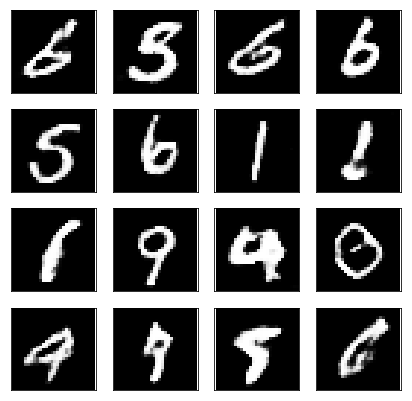

Epoch 7/10... Discriminator Loss: 0.6124... Generator Loss: 1.1628
Epoch 7/10... Discriminator Loss: 0.6227... Generator Loss: 1.1937
Epoch 7/10... Discriminator Loss: 1.1940... Generator Loss: 0.5288
Epoch 7/10... Discriminator Loss: 0.8211... Generator Loss: 0.8688
Epoch 7/10... Discriminator Loss: 0.5980... Generator Loss: 2.3086
Epoch 7/10... Discriminator Loss: 0.5645... Generator Loss: 2.4380
Epoch 7/10... Discriminator Loss: 0.7163... Generator Loss: 1.0132
Epoch 8/10... Discriminator Loss: 0.6694... Generator Loss: 1.2646
Epoch 8/10... Discriminator Loss: 0.4929... Generator Loss: 1.3956
Epoch 8/10... Discriminator Loss: 0.6443... Generator Loss: 1.3190


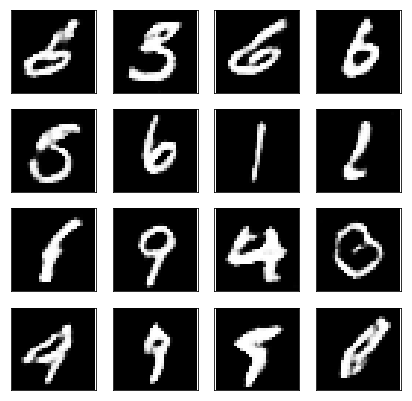

Epoch 8/10... Discriminator Loss: 1.2638... Generator Loss: 3.4477
Epoch 8/10... Discriminator Loss: 0.7233... Generator Loss: 1.4669
Epoch 8/10... Discriminator Loss: 0.6321... Generator Loss: 1.2291
Epoch 8/10... Discriminator Loss: 0.5545... Generator Loss: 1.7301
Epoch 8/10... Discriminator Loss: 0.8103... Generator Loss: 0.9507
Epoch 8/10... Discriminator Loss: 0.7712... Generator Loss: 1.0549
Epoch 8/10... Discriminator Loss: 0.9075... Generator Loss: 0.7964
Epoch 8/10... Discriminator Loss: 0.6470... Generator Loss: 1.2316
Epoch 8/10... Discriminator Loss: 1.5432... Generator Loss: 0.4196
Epoch 8/10... Discriminator Loss: 0.7789... Generator Loss: 1.0339


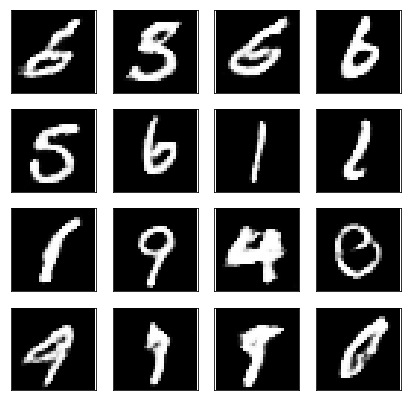

Epoch 8/10... Discriminator Loss: 0.8017... Generator Loss: 2.3768
Epoch 8/10... Discriminator Loss: 0.7291... Generator Loss: 1.1408
Epoch 8/10... Discriminator Loss: 0.5299... Generator Loss: 1.7424
Epoch 8/10... Discriminator Loss: 1.0000... Generator Loss: 0.6348
Epoch 8/10... Discriminator Loss: 0.6303... Generator Loss: 1.9234
Epoch 8/10... Discriminator Loss: 1.1822... Generator Loss: 3.0827
Epoch 8/10... Discriminator Loss: 0.7919... Generator Loss: 2.5594
Epoch 8/10... Discriminator Loss: 0.6408... Generator Loss: 2.0102
Epoch 8/10... Discriminator Loss: 1.0204... Generator Loss: 2.0987
Epoch 8/10... Discriminator Loss: 0.7658... Generator Loss: 1.0881


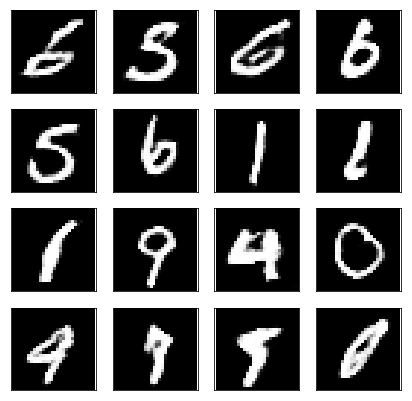

Epoch 8/10... Discriminator Loss: 0.6858... Generator Loss: 1.1806
Epoch 8/10... Discriminator Loss: 0.6062... Generator Loss: 1.7125
Epoch 8/10... Discriminator Loss: 0.6954... Generator Loss: 2.0914
Epoch 8/10... Discriminator Loss: 1.2419... Generator Loss: 0.5351
Epoch 8/10... Discriminator Loss: 1.0092... Generator Loss: 0.5932
Epoch 8/10... Discriminator Loss: 0.8082... Generator Loss: 0.8727
Epoch 8/10... Discriminator Loss: 0.7447... Generator Loss: 0.9680
Epoch 8/10... Discriminator Loss: 0.5003... Generator Loss: 1.9407
Epoch 8/10... Discriminator Loss: 0.5292... Generator Loss: 1.3514
Epoch 8/10... Discriminator Loss: 0.5286... Generator Loss: 1.6717


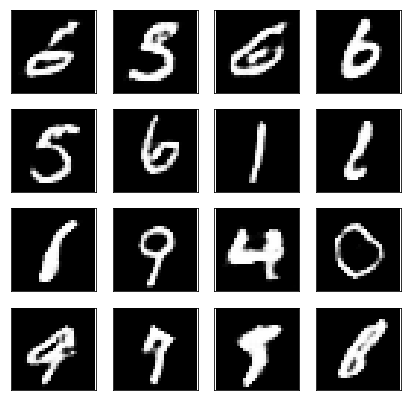

Epoch 8/10... Discriminator Loss: 0.8034... Generator Loss: 0.8582
Epoch 8/10... Discriminator Loss: 0.8257... Generator Loss: 0.9371
Epoch 8/10... Discriminator Loss: 0.8799... Generator Loss: 0.7789
Epoch 8/10... Discriminator Loss: 1.0254... Generator Loss: 3.0323
Epoch 8/10... Discriminator Loss: 0.7630... Generator Loss: 1.0590
Epoch 8/10... Discriminator Loss: 1.7766... Generator Loss: 0.2918
Epoch 8/10... Discriminator Loss: 1.0753... Generator Loss: 2.4679
Epoch 8/10... Discriminator Loss: 1.1827... Generator Loss: 0.5231
Epoch 8/10... Discriminator Loss: 0.5147... Generator Loss: 2.4325
Epoch 8/10... Discriminator Loss: 0.7067... Generator Loss: 1.8895


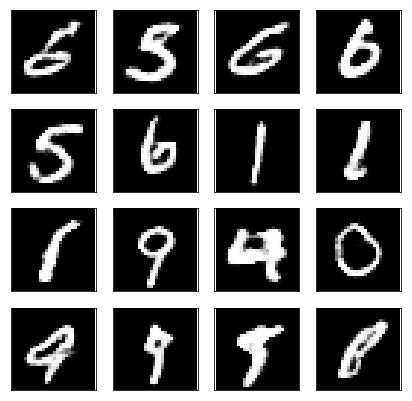

Epoch 8/10... Discriminator Loss: 0.7130... Generator Loss: 1.7794
Epoch 8/10... Discriminator Loss: 1.1984... Generator Loss: 0.5252
Epoch 8/10... Discriminator Loss: 0.7507... Generator Loss: 1.4114
Epoch 8/10... Discriminator Loss: 0.7272... Generator Loss: 0.9633
Epoch 9/10... Discriminator Loss: 0.6559... Generator Loss: 1.2977
Epoch 9/10... Discriminator Loss: 0.5653... Generator Loss: 1.3838
Epoch 9/10... Discriminator Loss: 1.3139... Generator Loss: 0.4729
Epoch 9/10... Discriminator Loss: 1.0456... Generator Loss: 0.6426
Epoch 9/10... Discriminator Loss: 0.9291... Generator Loss: 0.8048
Epoch 9/10... Discriminator Loss: 0.7759... Generator Loss: 0.9792


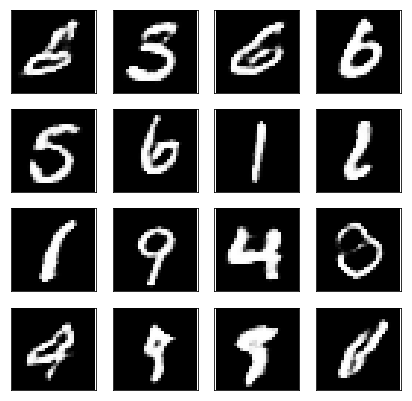

Epoch 9/10... Discriminator Loss: 1.1217... Generator Loss: 0.5792
Epoch 9/10... Discriminator Loss: 0.7023... Generator Loss: 0.9895
Epoch 9/10... Discriminator Loss: 1.5671... Generator Loss: 0.3593
Epoch 9/10... Discriminator Loss: 0.5152... Generator Loss: 1.6362
Epoch 9/10... Discriminator Loss: 0.5426... Generator Loss: 2.2578
Epoch 9/10... Discriminator Loss: 0.6800... Generator Loss: 1.0352
Epoch 9/10... Discriminator Loss: 0.5476... Generator Loss: 1.4268
Epoch 9/10... Discriminator Loss: 0.6865... Generator Loss: 0.9413
Epoch 9/10... Discriminator Loss: 0.9477... Generator Loss: 0.7145
Epoch 9/10... Discriminator Loss: 0.7613... Generator Loss: 1.0527


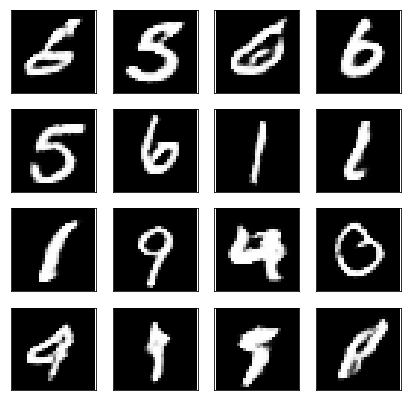

Epoch 9/10... Discriminator Loss: 0.5537... Generator Loss: 1.7886
Epoch 9/10... Discriminator Loss: 0.9849... Generator Loss: 0.7317
Epoch 9/10... Discriminator Loss: 0.5797... Generator Loss: 1.2831
Epoch 9/10... Discriminator Loss: 1.0101... Generator Loss: 0.6668
Epoch 9/10... Discriminator Loss: 0.6390... Generator Loss: 1.2627
Epoch 9/10... Discriminator Loss: 0.8129... Generator Loss: 0.7939
Epoch 9/10... Discriminator Loss: 0.8698... Generator Loss: 0.7935
Epoch 9/10... Discriminator Loss: 0.7946... Generator Loss: 0.8823
Epoch 9/10... Discriminator Loss: 0.6860... Generator Loss: 1.2031
Epoch 9/10... Discriminator Loss: 0.9552... Generator Loss: 0.7326


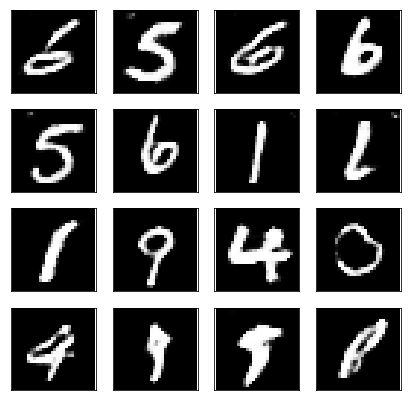

Epoch 9/10... Discriminator Loss: 0.7343... Generator Loss: 0.9391
Epoch 9/10... Discriminator Loss: 0.5674... Generator Loss: 1.2842
Epoch 9/10... Discriminator Loss: 0.7210... Generator Loss: 0.9929
Epoch 9/10... Discriminator Loss: 2.1555... Generator Loss: 0.2357
Epoch 9/10... Discriminator Loss: 0.9102... Generator Loss: 0.7437
Epoch 9/10... Discriminator Loss: 0.6590... Generator Loss: 1.5784
Epoch 9/10... Discriminator Loss: 0.5472... Generator Loss: 1.6501
Epoch 9/10... Discriminator Loss: 0.6064... Generator Loss: 1.4776
Epoch 9/10... Discriminator Loss: 0.5349... Generator Loss: 1.6984
Epoch 9/10... Discriminator Loss: 0.7575... Generator Loss: 0.9678


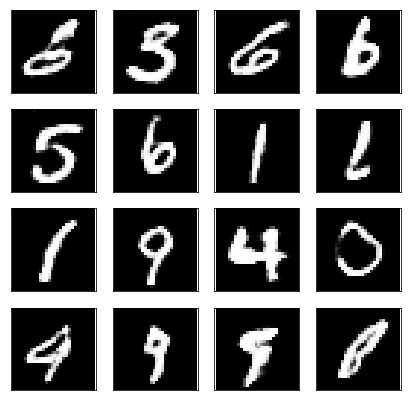

Epoch 9/10... Discriminator Loss: 0.6957... Generator Loss: 1.2141
Epoch 9/10... Discriminator Loss: 0.8475... Generator Loss: 0.8938
Epoch 9/10... Discriminator Loss: 0.5531... Generator Loss: 1.5203
Epoch 9/10... Discriminator Loss: 0.6588... Generator Loss: 1.8831
Epoch 9/10... Discriminator Loss: 0.7604... Generator Loss: 0.9394
Epoch 9/10... Discriminator Loss: 0.6212... Generator Loss: 1.4482
Epoch 9/10... Discriminator Loss: 0.7241... Generator Loss: 1.0172
Epoch 9/10... Discriminator Loss: 0.4717... Generator Loss: 1.8075
Epoch 9/10... Discriminator Loss: 0.4817... Generator Loss: 1.7193
Epoch 9/10... Discriminator Loss: 0.5853... Generator Loss: 1.2544


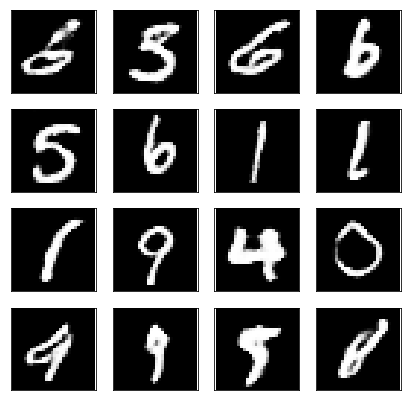

Epoch 9/10... Discriminator Loss: 0.8559... Generator Loss: 2.2504
Epoch 10/10... Discriminator Loss: 0.8956... Generator Loss: 0.7569
Epoch 10/10... Discriminator Loss: 0.6331... Generator Loss: 1.2887
Epoch 10/10... Discriminator Loss: 0.4758... Generator Loss: 1.5306
Epoch 10/10... Discriminator Loss: 0.4299... Generator Loss: 2.2774
Epoch 10/10... Discriminator Loss: 2.1963... Generator Loss: 0.2520
Epoch 10/10... Discriminator Loss: 1.2641... Generator Loss: 0.5560
Epoch 10/10... Discriminator Loss: 1.1570... Generator Loss: 0.5492
Epoch 10/10... Discriminator Loss: 0.7144... Generator Loss: 1.1171
Epoch 10/10... Discriminator Loss: 0.8387... Generator Loss: 0.8075


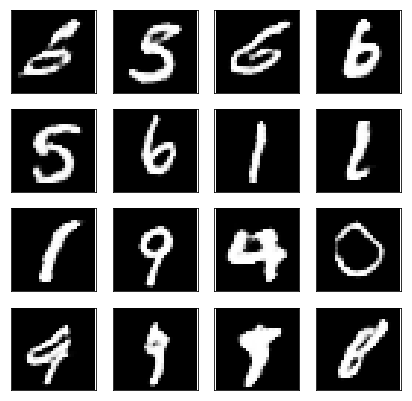

Epoch 10/10... Discriminator Loss: 0.5380... Generator Loss: 1.6885
Epoch 10/10... Discriminator Loss: 0.5544... Generator Loss: 1.5246
Epoch 10/10... Discriminator Loss: 0.6293... Generator Loss: 1.7969
Epoch 10/10... Discriminator Loss: 0.5345... Generator Loss: 1.4688
Epoch 10/10... Discriminator Loss: 0.5476... Generator Loss: 1.6577
Epoch 10/10... Discriminator Loss: 0.4819... Generator Loss: 1.7558
Epoch 10/10... Discriminator Loss: 0.6792... Generator Loss: 1.9941
Epoch 10/10... Discriminator Loss: 1.6536... Generator Loss: 0.3255
Epoch 10/10... Discriminator Loss: 0.6346... Generator Loss: 1.3769
Epoch 10/10... Discriminator Loss: 0.9469... Generator Loss: 0.7324


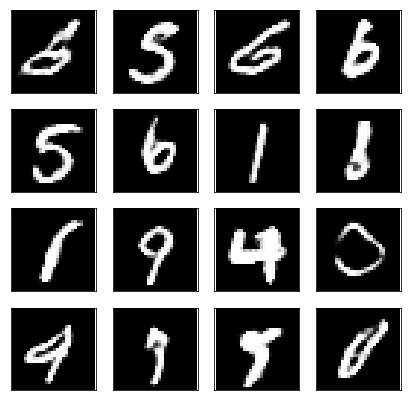

Epoch 10/10... Discriminator Loss: 0.5372... Generator Loss: 1.5868
Epoch 10/10... Discriminator Loss: 0.5504... Generator Loss: 1.3669
Epoch 10/10... Discriminator Loss: 0.6224... Generator Loss: 1.2859
Epoch 10/10... Discriminator Loss: 1.1487... Generator Loss: 3.2360
Epoch 10/10... Discriminator Loss: 0.7357... Generator Loss: 0.9292
Epoch 10/10... Discriminator Loss: 0.6659... Generator Loss: 1.0889
Epoch 10/10... Discriminator Loss: 0.6157... Generator Loss: 1.4048
Epoch 10/10... Discriminator Loss: 0.5842... Generator Loss: 1.4993
Epoch 10/10... Discriminator Loss: 0.5880... Generator Loss: 1.8193
Epoch 10/10... Discriminator Loss: 0.6201... Generator Loss: 1.1832


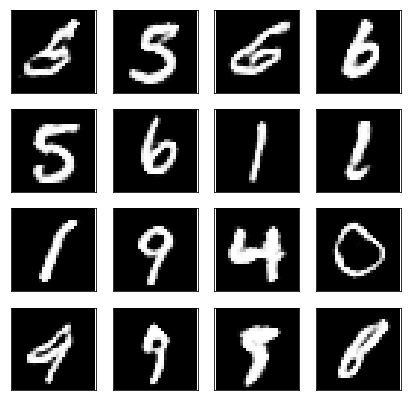

Epoch 10/10... Discriminator Loss: 0.5927... Generator Loss: 1.7505
Epoch 10/10... Discriminator Loss: 0.7430... Generator Loss: 1.2837
Epoch 10/10... Discriminator Loss: 0.7807... Generator Loss: 1.8078
Epoch 10/10... Discriminator Loss: 0.6638... Generator Loss: 1.1796
Epoch 10/10... Discriminator Loss: 0.8670... Generator Loss: 0.8959
Epoch 10/10... Discriminator Loss: 0.6297... Generator Loss: 1.1366
Epoch 10/10... Discriminator Loss: 0.7229... Generator Loss: 1.1867
Epoch 10/10... Discriminator Loss: 1.1596... Generator Loss: 0.5584
Epoch 10/10... Discriminator Loss: 0.6892... Generator Loss: 1.0592
Epoch 10/10... Discriminator Loss: 0.5289... Generator Loss: 1.2669


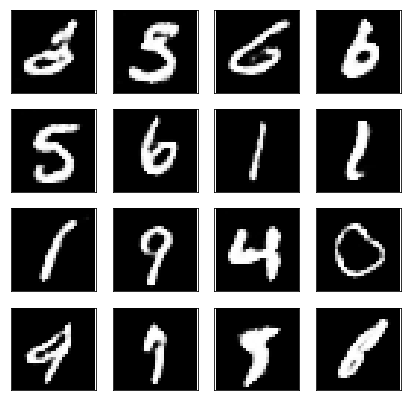

Epoch 10/10... Discriminator Loss: 0.9777... Generator Loss: 0.7061
Epoch 10/10... Discriminator Loss: 1.0451... Generator Loss: 0.6048
Epoch 10/10... Discriminator Loss: 0.5019... Generator Loss: 1.7173
Epoch 10/10... Discriminator Loss: 0.7810... Generator Loss: 1.9040
Epoch 10/10... Discriminator Loss: 0.5604... Generator Loss: 1.9776
Epoch 10/10... Discriminator Loss: 0.5992... Generator Loss: 1.1604
Epoch 10/10... Discriminator Loss: 0.6600... Generator Loss: 1.0757
Epoch 10/10... Discriminator Loss: 0.9362... Generator Loss: 0.7881


In [11]:
print_every = 10
show_every = 100

saver = tf.train.Saver()
sample_z = np.random.uniform(-1, 1, size=(72, z_size))

samples, losses = [], []
steps = 0

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            steps += 1
            
            # Batch Images
            x = mnist.train.next_batch(batch_size)[0]
            
            # Sample random noise for Generator
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # Run optimizers
            _ = sess.run(d_opt, feed_dict={input_real: x, input_z: batch_z})
            _ = sess.run(g_opt, feed_dict={input_real: x, input_z: batch_z})
            
            if steps % print_every == 0:
                # At the end of each epoch, get the losses and print them out
                train_loss_d = d_loss.eval({input_z: batch_z, input_real: x})
                train_loss_g = g_loss.eval({input_z: batch_z})

                print("Epoch {}/{}...".format(e+1, epochs),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                # Save losses to view after training
                losses.append((train_loss_d, train_loss_g))
                
            
            if steps % show_every == 0:
                gen_samples = sess.run(
                               generator(input_z, 1, reuse=True, training=False),
                               feed_dict={input_z: sample_z})
                samples.append(gen_samples)
                _ = view_samples(-1, samples)
                plt.show()

    saver.save(sess, './checkpoints/generator.ckpt')

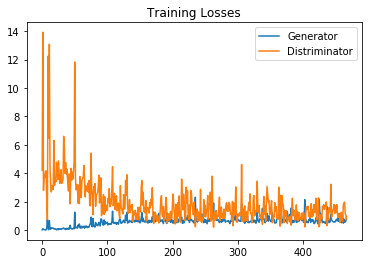

In [12]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Generator')
plt.plot(losses.T[1], label='Distriminator')
plt.title("Training Losses")
plt.legend()